In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
from dsp.Runner import SequenceSolver
from dsp.Problem import Problem
from dsp.Solver import DPSolver
from dtspx_ampl import ampl_solve
import pandas as pd
import pprint as pp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from multiprocessing import Pool
import pickle

In [5]:
# Time frame
T = 6

# Data
x_data = np.genfromtxt("data/x.csv", delimiter=",")
y_data = np.genfromtxt("data/y.csv", delimiter=",")

xy_data = np.stack([x_data, y_data], axis=2)

# Create sequence solver object
P = Problem(xy_data, T=T)
root = DPSolver(P, seq=[])

ALPHA = set(P.in_working_area)
np.random.seed(10)



In [49]:
PF = {
    '4' : np.array([0, 41.1, 42.8, 43.4, 46.6, 47.3, 48.7, 50.5, 53.8, 60.0, 70.1, 80.8, 90.1, 100.6, 115.0, 128.2]), 
    '6' : np.array([0, 29.6, 41.3, 42.9, 43.5, 46.6, 47.3, 48.7, 50.5, 53.8, 55.4, 60.5, 70.6, 81.4, 89.5, 99.5, 110.6, 124.4, 176.2, 190.4, 209.8]),
    '8' : np.array([0, 29.6, 41.3, 42.9, 43.5, 46.2, 47.3, 48.7, 50.3, 51.0, 52.5, 55.8, 57.3, 61.9, 67.2, 76.8, 81.5, 86.7, 94.4, 107.2, 112.8, 122.2, 133.2, 147.1, 159.4, 173.3])    
}

In [7]:
SeqSolver = SequenceSolver(problem=P, root=root, height_limit=20)

In [10]:
results = []
weights = np.linspace(0, 1, 50)
def solve(w):
    print(f"Starting weight: {w}")
    truncation_args = {
        'limit' : 1000,
        'method': 'decomposition',
        'w' : w
    }
    
    result = SeqSolver.sequence_search(available=ALPHA,
                                       truncation_args=truncation_args)
    with open(f'results/exp1/variable_weight_decomp_{round(w, 2)}.pickle', 'wb') as fp:
        pickle.dump(result, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    print(f"finished weight: {w}")
    return result

with Pool(processes=8) as pool:
    results = pool.map(solve, weights)

Starting weight: 0.12244897959183673
Starting weight: 0.08163265306122448
Starting weight: 0.16326530612244897
Starting weight: 0.04081632653061224
Starting weight: 0.24489795918367346
Starting weight: 0.2857142857142857
Starting weight: 0.0
Starting weight: 0.2040816326530612
Finished
finished weight: 0.2040816326530612
Starting weight: 0.22448979591836732
Finished
finished weight: 0.24489795918367346
Starting weight: 0.26530612244897955
Finished
finished weight: 0.08163265306122448
Starting weight: 0.1020408163265306
Finished
finished weight: 0.0
Starting weight: 0.02040816326530612
Finished
finished weight: 0.04081632653061224
Starting weight: 0.061224489795918366
Finished
finished weight: 0.12244897959183673
Starting weight: 0.14285714285714285
Finished
finished weight: 0.16326530612244897
Starting weight: 0.18367346938775508
Finished
finished weight: 0.2857142857142857
Starting weight: 0.3061224489795918
Finished
finished weight: 0.22448979591836732
Starting weight: 0.326530612244

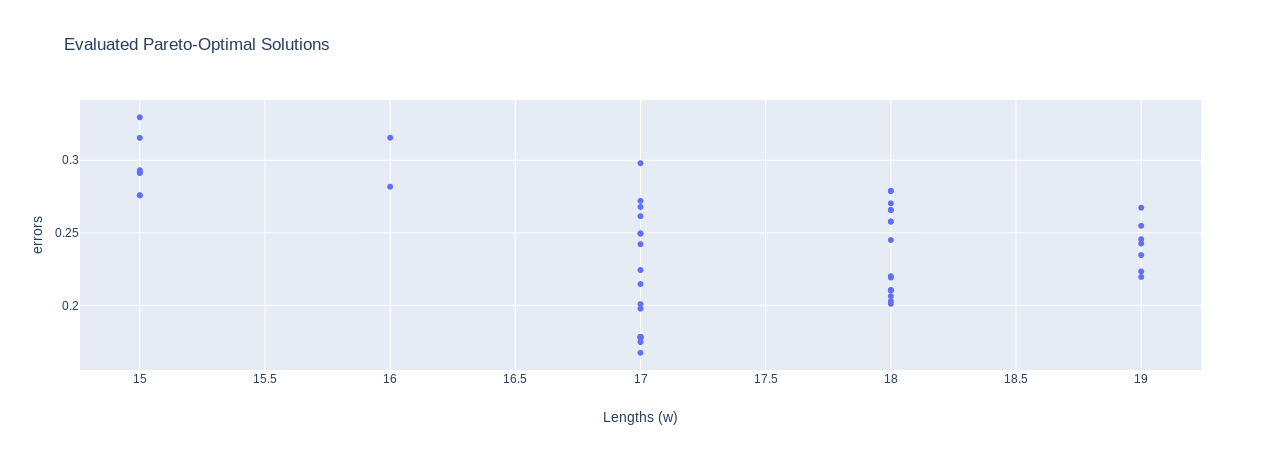

In [46]:
seq_lengths = []
errors = []

for res in results: 
    seq_lengths.append((len(res['best_dist'])-1))
    sol = res['best_dist'][1:]
    error = np.mean((np.array(sol) - PF['8'][:len(sol)])/PF['8'][:len(sol)])
    errors.append(error)

# fig = make_subplots(specs=[[{"secondary_y": True}]])
fig = go.Figure()
# fig.add_trace(go.Scatter(x=weights, y=seq_lengths, name="Sequence Length"))
fig.add_trace(go.Scatter(x=seq_lengths, y=errors, name="Average Error", mode='markers'))
barmode='stack'
# The two histograms are drawn on top of another
fig.update_layout(title='Evaluated Pareto-Optimal Solutions', 
                  xaxis_title="Lengths (w)", yaxis_title="errors")

# fig.update_yaxes(title_text="Seqence Length (Alpha)", secondary_y=False)
# fig.update_yaxes(title_text="Average Error", secondary_y=True)
                 
fig.show()

## Analyzing loss of an algorithm across Alpha

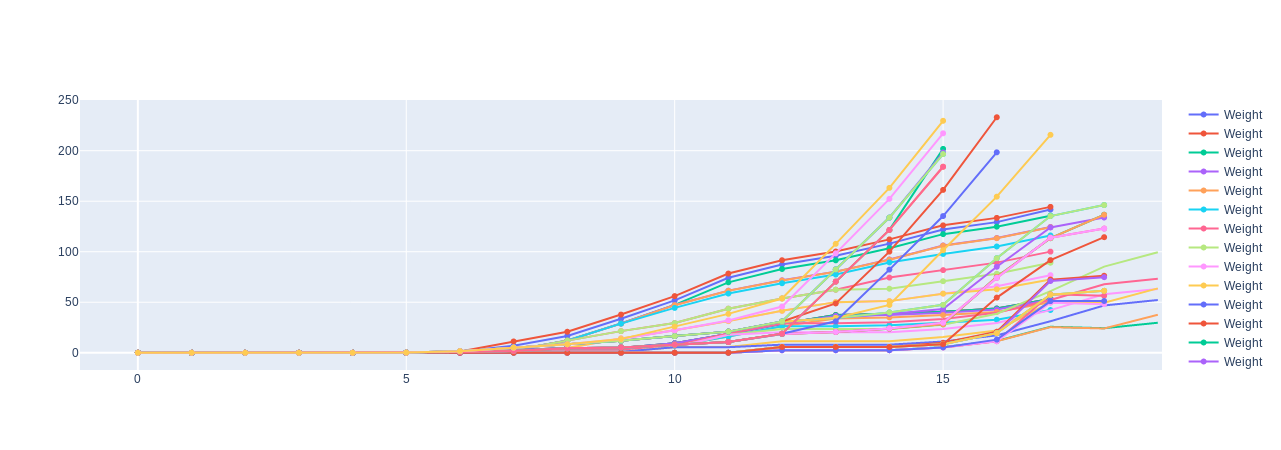

In [57]:
pf = PF[str(T)]

fig = go.Figure()

for res in results: 
    sol = res['best_dist']
    y = np.cumsum(np.around(np.array(sol), 1) - pf[:len(sol)])
    fig.add_trace(go.Scatter(x=np.arange(len(sol)), y=y, name=f"Weight"))
#     for l, sol in enumerate(res['best_dist'])
        
fig.show()